In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [99]:
import warnings
warnings.filterwarnings('ignore')

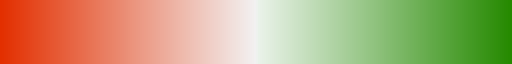

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")
hm_w = 10
hm_h = 4
set_title = False
sns.set(font_scale = 1.8)
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

In [3]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [54]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [55]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 2) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [56]:
def create_heatmap(df, columns, title, fname):
    fig, ax = plt.subplots(figsize=(hm_w, hm_h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
    g.invert_yaxis()
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [300]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,7.475425e+08
1,row,1.113718e+09


In [301]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.434524,0.42


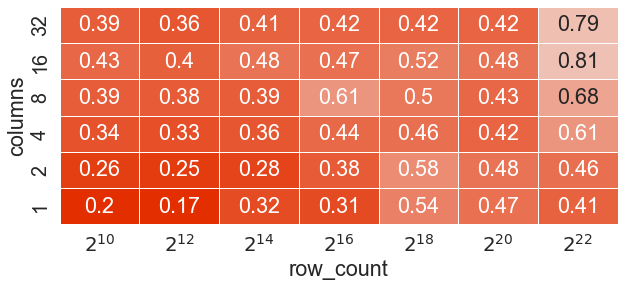

In [302]:
create_heatmap(reorder_total_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (incl. scatter + gather)',
               'reorder_incl_sg')

In [303]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.392619,1.275


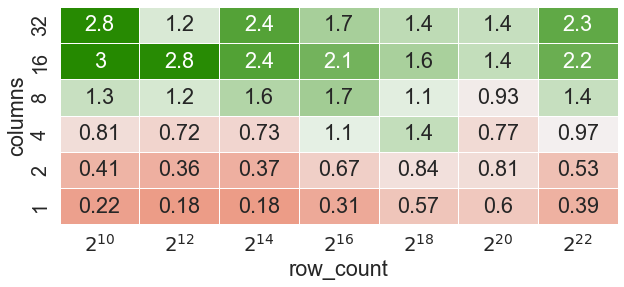

In [60]:
create_heatmap(reorder_only_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (excl. scatter + gather)',
               'reorder_excl_sg')

In [12]:
con.execute("""
    select
        cast(log2(count) as int) as row_count,
        columns,
        col_width,
        reorder as "row reorder",
        round(cast(scatter + gather as double) / total, 2) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        row_count asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.554048,0.595


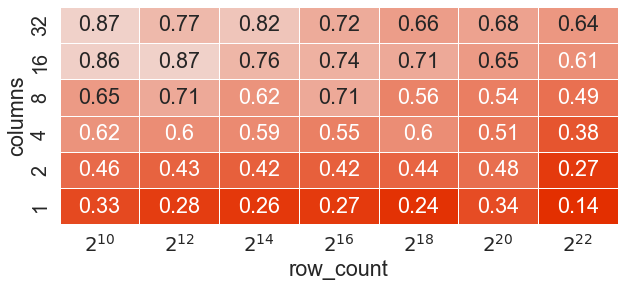

In [13]:
create_heatmap(reorder_percentage_df,
               ['columns', 'row_count', 'sg'],
               'scatter + gather as percentage of reorder runtime',
               'reorder_sg_percentage')

# Comparator

In [14]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,4.661965e+09
1,col_ss,1.232953e+09
2,row_branched,2.226768e+09
3,row_branchless,1.276173e+09


In [15]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,2.840238,2.95


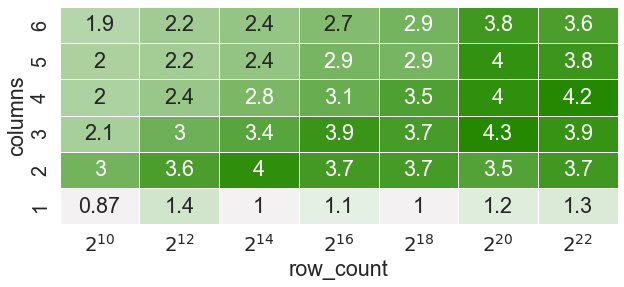

In [16]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. columnar_all (pdqsort)',
               'comparator_col_iter')

In [17]:
comparator_row_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branched', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.54381,0.5


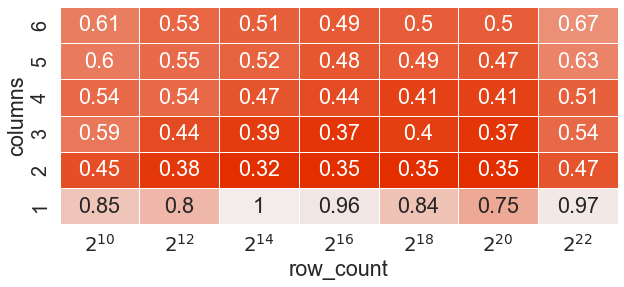

In [18]:
create_heatmap(comparator_row_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_key vs. columnar_iterative (pdqsort)',
               'comparator_row_key')

In [19]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.821429,0.845


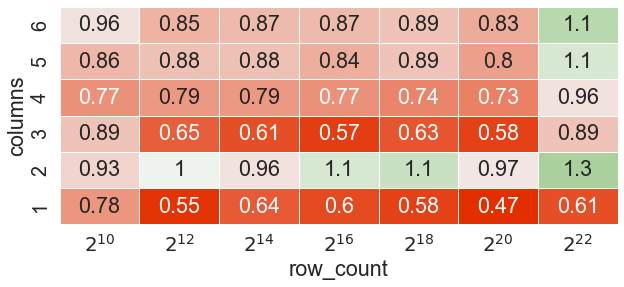

In [20]:
create_heatmap(comparator_norm_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'normalized_key vs. columnar_iterative (pdqsort)',
               'comparator_norm_key')

# Sort

In [21]:
sort_df = load_csv(con, 'results/sort.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_dynamic,1.973278e+09
1,pdq_static,1.138500e+09
2,radix,1.186486e+09


In [22]:
sort_static_radix_df = compute_relative_runtime(con, sort_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_static_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.709762,0.77


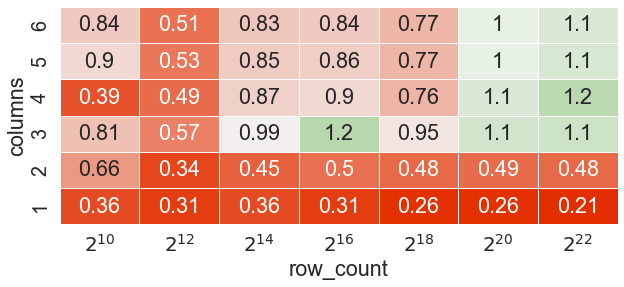

In [23]:
create_heatmap(sort_static_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_static')

In [24]:
sort_dynamic_radix_df = compute_relative_runtime(con, sort_df, 'pdq_dynamic', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_dynamic_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.570238,1.31


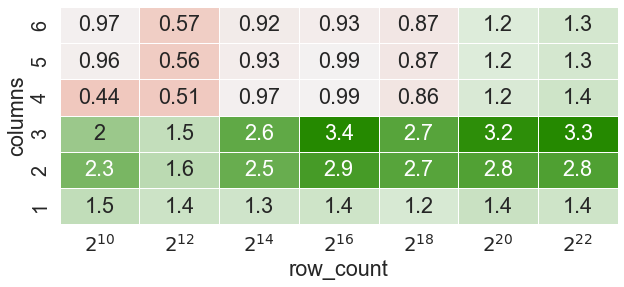

In [25]:
create_heatmap(sort_dynamic_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_dynamic vs. radix',
               'sort_dynamic')

# Merge Key

In [26]:
merge_key_df = load_csv(con, 'results/merge_key.csv', ['total'])
con.execute("select category, sum(total) from merge_key_df group by category")
con.fetchdf()

,category,sum(total)
0,col,151533039.0
1,row,122594870.0


In [27]:
merge_key_runtime = compute_relative_runtime(con, merge_key_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_key_runtime")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.282857,1.225


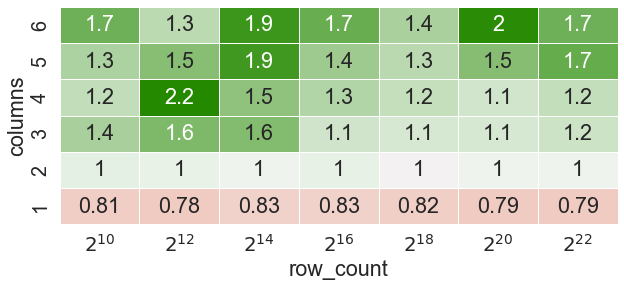

In [28]:
create_heatmap(merge_key_runtime,
               ['columns', 'row_count', 'relative_runtime'],
               'merge normalized key vs. merge key columnar',
               'merge_key')

# Merge Payload

In [304]:
merge_payload_df = load_csv(con, 'results/merge_payload.csv', ['total'])
con.execute("select category, sum(total) from merge_payload_df group by category")
con.fetchdf()

,category,sum(total)
0,col,722536164.0
1,row,472553543.0


In [289]:
merge_payload_runtime_df = compute_relative_runtime(con, merge_payload_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_payload_runtime_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.520476,1.305


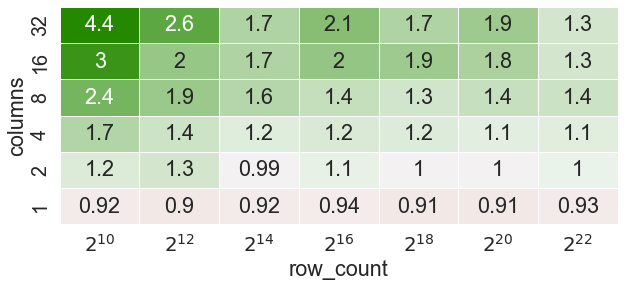

In [290]:
create_heatmap(merge_payload_runtime_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge_payload')

# Static vs. Dynamic

In [156]:
paired = sns.color_palette('Paired')
mem_colors = [paired[3], paired[7]]
paired

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [296]:
con.execute("""
select 'memcpy' as function, * from read_csv_auto('results/memcpy.csv')
union all
select 'memcmp' as function, * from read_csv_auto('results/memcmp.csv')
""")
mem_df = con.fetchdf()

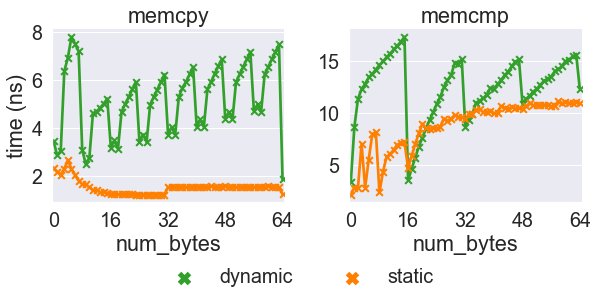

In [297]:
plot = sns.catplot(data=mem_df, kind='point', x='num_bytes', y='time', col='function', hue='type', col_wrap=2,
                   sharex=True, sharey=False, markers=['x', 'x'], height=4.5, aspect=0.75, palette=mem_colors)

plot.axes[0].set_ylabel('time (ns)')
plot.axes[1].set_ylabel('')
plot.axes[0].set_title('memcpy')
plot.axes[1].set_title('memcmp')
for ind, label in enumerate(plot.axes[0].get_xticklabels()):
    label.set_visible(ind % 16 == 0)
    
for ind, label in enumerate(plot.axes[1].get_xticklabels()):
    label.set_visible(ind % 16 == 0)

plot._legend.set_visible(False)
handles, labels = plot.axes[0].get_legend_handles_labels()
lgnd = plot.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=len(labels), frameon=False)
for lh in lgnd.legendHandles:
    lh._sizes = [100]
    lh._linewidths = [5]

plt.tight_layout()
plot.fig.subplots_adjust(bottom=0.325)
plt.savefig('figures/mem.eps', bbox_inches='tight')

In [295]:
con.execute("""
select max(d.time / s.time) as speedup, d.function, d.num_bytes
from mem_df d, mem_df s
where d.type = 'dynamic'
and s.type = 'static'
and d.function = s.function
and d.num_bytes = s.num_bytes
group by d.function, d.num_bytes
order by speedup asc
""")
speedup = con.fetchdf()
speedup.head(20)

,speedup,function,num_bytes
0,0.788666,memcmp,16
1,0.789111,memcmp,17
2,0.813310,memcmp,18
3,0.831208,memcmp,19
4,0.848900,memcmp,20
5,0.929022,memcmp,32
6,0.973121,memcmp,33
7,0.992332,memcmp,34
8,1.016653,memcmp,21
9,1.044695,memcmp,35


# Trace

In [32]:
# TODO

# Templating ...

In [298]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn memcmp_fixed<{i}>(str1, str2);')

	case 1:
		return MemcmpFixed<1>(str1, str2);
	case 2:
		return MemcmpFixed<2>(str1, str2);
	case 3:
		return MemcmpFixed<3>(str1, str2);
	case 4:
		return MemcmpFixed<4>(str1, str2);
	case 5:
		return MemcmpFixed<5>(str1, str2);
	case 6:
		return MemcmpFixed<6>(str1, str2);
	case 7:
		return MemcmpFixed<7>(str1, str2);
	case 8:
		return MemcmpFixed<8>(str1, str2);
	case 9:
		return MemcmpFixed<9>(str1, str2);
	case 10:
		return MemcmpFixed<10>(str1, str2);
	case 11:
		return MemcmpFixed<11>(str1, str2);
	case 12:
		return MemcmpFixed<12>(str1, str2);
	case 13:
		return MemcmpFixed<13>(str1, str2);
	case 14:
		return MemcmpFixed<14>(str1, str2);
	case 15:
		return MemcmpFixed<15>(str1, str2);
	case 16:
		return MemcmpFixed<16>(str1, str2);
	case 17:
		return MemcmpFixed<17>(str1, str2);
	case 18:
		return MemcmpFixed<18>(str1, str2);
	case 19:
		return MemcmpFixed<19>(str1, str2);
	case 20:
		return MemcmpFixed<20>(str1, str2);
	case 21:
		return MemcmpFixed<21>(str1, str2);
	case 22:


In [299]:
for i in range(1, 257):
    print(f'\tcase {i}:')
    print(f'\t\treturn MemcpyFixed<{i}>(dest, src);')

	case 1:
		return MemcpyFixed<1>(dest, src);
	case 2:
		return MemcpyFixed<2>(dest, src);
	case 3:
		return MemcpyFixed<3>(dest, src);
	case 4:
		return MemcpyFixed<4>(dest, src);
	case 5:
		return MemcpyFixed<5>(dest, src);
	case 6:
		return MemcpyFixed<6>(dest, src);
	case 7:
		return MemcpyFixed<7>(dest, src);
	case 8:
		return MemcpyFixed<8>(dest, src);
	case 9:
		return MemcpyFixed<9>(dest, src);
	case 10:
		return MemcpyFixed<10>(dest, src);
	case 11:
		return MemcpyFixed<11>(dest, src);
	case 12:
		return MemcpyFixed<12>(dest, src);
	case 13:
		return MemcpyFixed<13>(dest, src);
	case 14:
		return MemcpyFixed<14>(dest, src);
	case 15:
		return MemcpyFixed<15>(dest, src);
	case 16:
		return MemcpyFixed<16>(dest, src);
	case 17:
		return MemcpyFixed<17>(dest, src);
	case 18:
		return MemcpyFixed<18>(dest, src);
	case 19:
		return MemcpyFixed<19>(dest, src);
	case 20:
		return MemcpyFixed<20>(dest, src);
	case 21:
		return MemcpyFixed<21>(dest, src);
	case 22:
		return MemcpyFixed<